#<center>BTC/USDT Analysis</center>












## Recurrent Deep Learning Approach


### 1.1 Pre Discussion

If nothing else, I urge the reader to read the summary section just after section 1.7. There I briefly discuss the main components of this approach, as well as where I believe the sources of failure are located.

### Time scale
I believe that when dealing with large timescales (1h, 4h, 1d, ...) crypto analysis is best done by humans considering real world data, such as political activity, public sentiment, etc., which I'll call "macro variables". However, as smaller timescales are used, there is a tradeoff between the macro-variables and micro-variables. I believe the micro-variables are more predictable using purely numerical methods, though with each smaller timescale there is a stronger element of randomness. It will be important to find the right balance between these three influences.

---

### Data sampling
This comes with its own set of challenges, the first which comes to mind and will need to be addressed is the sampling of the data. Fundamentally, RNNs require the data to be ordered, and use the timestamp of the data to remember certain patterns for further use. I will make sure to not shuffle the data at any point.

---

### Data Labelling
The data will be labelled using the grader function from my previous attempts. This will be discussed below, so don't worry. At this point, this is still the best option I have with my knowledge, and so I will continue to use it.

---

### Data formatting
For the prototyping phase, I will severely shorten the data set so that computations can be done quickly. Once the overall model structure is built, I will use the full dataset. One consideration for data formatting is that the data will need to be trimmed on both ends, depending on:
* The length of indicators used (such as moving averages, standard deviation): For example, a 20-pt moving average will need at least 20 data points prior to be properly calculated. If 20-pt was the largest used in the data, then the oldest 20 data points would need to be removed after the MA is calculated.
* The 'n' parameter of the grader function: If the algorithm is trained based on labels that look 40 data points into the future to evaluate the success of a trade, then the most recent 40 data points will need to be removed after the grader function is applied.


---


### LSTM Discussion

The grunt work setting up the data prep functions to be iterated over several times is now mostly complete, I need to start considering how this data will be parsed through to the RNN. It would seem that the LSTM layer is the golden child of RNN layers, and so that is what I will be using.

My initial reading shows that the fundamental difference between LSTM input data and regular input data is the LSTM now takes a rank 3 tensor with shape (batches, timestamps, features). This was very confusing at first, but after reading through the [TensorFlow Windowing section](https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing), I believe I understand.

Since I am predicting whether or not the current data point is a good long trade or short trade, I can specify immediately that the label width is 1, with 0 shift. For example, for a window length of 5 inputs, the data input for the LSTM layer might look like:

\begin{align}
    \text{df} = \begin{bmatrix} d_0 & d_1 & d_2 & d_3 & d_4\\
                                    d_1 & d_2 & d_3 & d_4 & d_5 \\
                                    \vdots & \vdots & \vdots & \vdots & \vdots \\
                                    d_{n-4} & d_{n-3} & d_{n-2} & d_{n-1} &d_n          
    \end{bmatrix}
\end{align}

Where df is our dataframe, each row represents one batch of data, and each of $d_i$ are themselves an array containing the features of our data (high, open, close, sma-20, sd-20, buy, sell, etc..). In this example, the last element of each batch would be used to determine the labels for that batch. Let's define some variables:

\begin{align}
    W &: \text{Window length}\\
    N &: \text{Number of data points}\\
    B &: \text{Number of batches}\\
    F &: \text{Number of features}
\end{align}

Then it would be nice to know the relationship between $B$, $N$, and $W$ for writing my data prep function. Using the frame df above, I can see that the final index of the first row is equal to our window length (using standard upper bound exclusion). There will be $n-5$ batches in df above, or, converting to our variables:
$$B = N-W$$


So, when constructing our tensor with window length specified, the frame dimensions should be
$$\text{shape} = (N-W,\;\;W,\;\;F)$$




### 1.2 Setup

#### Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [4]:
def get_sma(items, *args):
    """
    get_sma() function will return the simple moving average for the list "items" with period "n".
    Use of args here is redundant, but I was planning on adding more to this function later.
    """
    items = copy.copy(items)
    n = args[0]
    return items.rolling(n).mean()

def get_sd(items, *args):
    """
    get_sd() function will return the standard deviation for the list "items" with period "n".
    Use of args here is redundant, but I was planning on adding more to this function later.
    """
    items = copy.copy(items)
    n = args[0]
    return items.rolling(n).std()

def normalize(df):
    return (df-df.min())/(df.max()-df.min())

raw = pd.read_csv("/content/drive/MyDrive/Machine Learning/BTCUSDT Analysis/binance_BTCUSDT_minute.csv", low_memory=False, sep=",", header = 1)
print(raw.columns)

Index(['unix', 'date', 'symbol', 'open', 'high', 'low', 'close', 'Volume BTC',
       'Volume USDT', 'tradecount'],
      dtype='object')


### 1.3 The Grader and DataPrep functions

The cornerstone of this approach is the grader function in the code block below. This is a compromise to label the data, since ideally the algorithm would be able to place both long and short orders, as well as vary the amount placed on each trade. However, I do not know of a way to allow the network to calculate the true value of a label during the training, as would be required for such a flexible algorithm.

Instead, I train the algorithm to always place long trades with specified stop-loss (SL) and take-profit (TP) levels. These levels are decided based on the following variables:

*    Reward/risk ratio: The reward to risk ratio is the ratio of potential profit to the potential loss.
*    Profit level: The desired TP level for the trade, in terms of percentage increase.

Both the reward to risk ratio and the profit level need to be specified to the grader function. The last missing piece is the amount of data points to check for the specified TP/SL levels. Of course, I could let the algorithm go on forever until either the TP or SL is triggered, but since the algorithm is designed to work on short timescales, I should limit the grader function to work in this scope.

With all these variables, the grader function executes as follows. Given the arguments:
* df     : A dataframe of shape (1,X) with all the closing prices is sent to the function.
* profit : The desired profit percentage on the trade
* rr     :The desired reward to risk ratio
* n      :The amount of data points to check

For every data point in 'df', the function will iterate over the next 'n' data points immediately following the current data point d[i]. If at any point d[i] exceeds the TP level (1+profit) or falls below the SL level (1-$profit/rr) then the current loop iteration will break and return 1 or 0. A 1 corresponds to a successful trade, and a 0 represents a failed trade.

In [5]:
def grader(df, type, *args):
    """
    Grader function, takes a pd DataFrame 'df' as input and outputs whether or not a buy (long trade) or
        a sell (short trade) at the current data point would trigger a stop loss or a take profit within
        'n_tries' data points at a reward/risk ratio and profit level of 'rr' and 'profit', respectively.
        df      :  pandas DataFrame with shape (1,x)
        type    :  String, "long" or "short" to indicate trade type
        profit  :  Number, The desired profit, in percentage form
        rr      :  Number, The reward/risk ratio, used to calculate stop-loss and take-profit
        n_tries :  Number, Number of data points to look into the future for the SL or TP

        Use of *args here is to simplify parsing of data later on through the DataPrep function.
    """
    # Unpack the args
    args = list(args)
    profit, rr, n_tries = args[0]

    # Make sure I am not modifying the original DataFrame
    df = copy.copy(df)

    if type is "long":
        sl = copy.copy(df) * (1-profit/rr)
        tp = copy.copy(df) * (1+profit)

        for i, close in enumerate(df):

            if i==df.shape[0] - n_tries:
                df.iloc[-n_tries:] = 0

            for k in range(i, i+n_tries):
                #SL Trigger
                if close <= sl.iloc[k]:
                    df.iloc[i] = 0
                    break
                #TP Trigger
                elif close >= tp.iloc[k]:
                    df.iloc[i] = 1
                    break
                df.iloc[i] = 0
        

        return df

    # If the trade type is short, I are looking for a TP below the close, with a corresponding SL above the close
    #     specified similarly by the profit and reward/risk ratio.
    elif type is "short":
        sl = copy.copy(df) * (1+profit/rr)
        tp = copy.copy(df) * (1-profit)

        for i, close in enumerate(df):

            if i==df.shape[0] - n_tries:
                df.iloc[-n_tries:] = 0

            for k in range(i, i+n_tries):
                #SL Trigger
                if close >= sl.iloc[k]:
                    df.iloc[i] = 0
                    break
                #TP Trigger
                elif close <= tp.iloc[k]:
                    df.iloc[i] = 1
                    break
                df.iloc[i] = 0
            
        return df

    # The trade was not properly specified, so return None
    return None

The DataPrep function is another large player in this approach. The idea is to have a single function which can be passed the raw data and output a completely formatted set of DataFrames which are ready to be passed to the LSTM layer. Here is the key functionality:


* Remove any undesired columns from the raw data, through use of the 'remove' parameter. 
* Add any desired technical indicators, through the use of the 'indicator_dict' dictionary, which pairs keywords to the technical indicator functions defined above. This information is parsed through the 'indicators' argument.
* Parameters for the grader function are passed through the 'grader_params' parameter, formatted as [profit, rr, n_tries]

The rest is relatively simple to explain and is documented in the DataPrep function below:

In [6]:
# As mentioned above, for the prototyping phase, only the a small sample will be used. I use a
pData = raw.iloc[:10187]

# Dictionary to parse the DataPrep function desired indicators to their respective functions
#    for calculation.
indicator_dict = {
    "sma" : get_sma,
    "sd" : get_sd
}

# DataFrame to hold any indicators that have already been calculated to optimize. All
#    indicators are calculated prior to any splitting or shuffling of data. Thus, they 
#    are consistent across several data prep cycles.
stored_indicators = pd.DataFrame();

def DataPrep(df, 
             test_ratio = 0.2,
             window_size = 10,
             return_frame = False,
             verbose = False,
             grader_params = [0.001, 2, 30],
             remove = ["date", "symbol", "Volume BTC", "tradecount"], 
             indicators = [("sma", 20), ("sd", 20), ("sma", 10), ("sd", 10)]
             ):
    """
        Parameters
    df            : Pandas DataFrame, The data set to prepare. Has known structure and layout.
    test_ratio    : Number between 0 and 1, The ratio of test data to training data
    window_size   : Number, the amount of data points per batch
    return_frame  : Whether or not I return the non-LSTM-modified DataFrame (useful for debugging)
    verbose       : Whether or not to print progress from the function call.
    grader_params : List, The parameters to be sent to the grader function (profit, rr, n)
    remove        : List, The columns to be removed
    indicators    : List, The indicators to be added
        Returns
    batch_train   : Pandas DataFrame, The training rank-3 tensor to be used in the LSTM layer (batches, window, features)
    batch_test    : Pandas DataFrame, The testing rank-3 tensor to be used in the LSTM layer (batches, window, features)
    train_labels  : Pandas DataFrame, The labels for the training data
    test_labels   : Pandas DataFrame, The labels for the testing data
    df            : Pandas DataFrame, Optional, The non-windowed DataFrame (index, features)
    """

    if verbose: print("Data prep start")
    # Define some variables to help trim later
    max_period = 0
    grader_period = grader_params[2]

    # Indexing and bulk removal -- Want oldest data first so RNN reads along positive time direction
    df = df[::-1]
    # Index differential is used to ensure that the list did in fact get reversed
    if verbose: print("...Indexing complete. Index differential: %i" %(df["unix"].iloc[1] - df["unix"].iloc[0]))
    df = df.drop(columns = remove)
    if verbose: print("...Columns removed")

    # Any base renaming to be done
    df["vol"] = copy.copy(df["Volume USDT"])
    df = df.drop("Volume USDT", axis=1)
    if verbose: print("...Renaming complete")

    # Indicator calculator. For each tuple in "indicators", relevant information
    #    is passed to add the desired indicator to the data set. If the indicator
    #    has already been calculated and stored in the stored_indicators list,
    #    it will pull from that instead of calulating it from scratch.
    if verbose: print("...Starting indicators")
    for item in indicators:

        #Identify the indicator and period
        indicator, period = item
        #Create the label "indicator-period"
        label = indicator + "-" + str(period)
        if verbose: print("      Indicator %s identified" %label)

        # I need to know the max period of the indicators to know how much data
        #    to trim from the beginning of the data set. This is to avoid NaN in
        #    our data.
        if period > max_period:
            max_period = period

        # If I have already calculated this label and it is stored in our list:
        if label in stored_indicators.columns:
            if verbose: print("      Indicator found in stored list")
            df[label] = copy.copy(stored_indicators[label])
        # If I have not yet calculated this label
        else:
            # Use the dictionary to calculate the desired indicator and store it in df
            df[label] = indicator_dict[indicator](df["close"], period)
            # Also store the indicator in the stored list for further use
            stored_indicators[label] = copy.copy(df[label])
            if verbose: print("      New indicator %s added to list" %label)

    if verbose: print("...Indicators complete")

    if verbose: print("...Grader function called")
    # Calculate the labels for the data set using the grader_params provided
    df["long"] = grader(df["close"], "long", grader_params)
    if verbose: print("      Long trade labels complete")
    df["short"] = grader(df["close"], "short", grader_params)
    if verbose: print("      Short trade labels complete")
    if verbose: print("...Grader function complete")

    

    # Trim the data set based on the largest indicator period and the grader period
    df = df.iloc[max_period : -1*grader_period]
    if verbose: print("...Data trimmed")

    # Normalize all the data
    for col in df.columns:
        df[col] = normalize(df[col]) 
    if verbose: print("...Data normalized") 
    


    # Create the train and test splits for the data
    train, test = train_test_split(df, test_size = test_ratio, shuffle=False)
    train_labels = copy.copy(train[["long", "short"]])
    train = train.drop(["long", "short"], axis=1)
    test_labels = copy.copy(test[["long", "short"]])
    test = test.drop(["long", "short"], axis=1)
    if verbose: print("...Train-test split created")

    # Define some variables to be used during the tensor creation
    train_batches = train.shape[0] - window_size
    test_batches = test.shape[0] - window_size
    num_features = train.shape[1]

    # Create the tensor for use in the LSTM layer -- This is much more optimized in the 
    #     2nd iteration DataPrep function in section 1.6.2
    if verbose: print("...Starting tensor creation")
    batch_train = np.empty(shape = (train_batches, window_size, num_features), dtype = np.float32)
    batch_test = np.empty(shape = (test_batches, window_size, num_features), dtype = np.float32)

    if verbose: print("      Train tensor with %i batches, %i window size" %(train_batches, window_size))
    for i in range(train_batches):
        for v in range(window_size):
            batch_train[i][v] = train.iloc[i + v]
    if verbose: print("      Train tensor created with shape :", batch_train.shape)

    if verbose: print("      Test tensor with %i batches, %i window size" %(test_batches, window_size))
    for i in range(test_batches):
        for v in range(window_size):
            batch_test[i][v] = test.iloc[i + v]
    if verbose: print("      Test tensor created with shape :", batch_test.shape)
    if verbose: print("...Tensor creation complete")
    if verbose: print("Data Prep Complete")



    if return_frame: return batch_train, batch_test, train_labels, test_labels, df

    return batch_train, batch_test, train_labels[window_size:], test_labels[window_size:]

In [9]:

pGraderParams = [0.001, 2, 50] # Aiming for a profit of 0.1%, reward/risk ratio of 2, and looking 50 ticks into the future
pWindowSize = 30 # Want the timesteps window size to have a width of 30

# Call the DataPrep function and get all our sets of data!
pxTrain, pxTest, pyTrain, pyTest = DataPrep(pData, verbose=True, window_size = pWindowSize, grader_params=pGraderParams) 

Data prep start
...Indexing complete. Index differential: 60000
...Columns removed
...Renaming complete
...Starting indicators
      Indicator sma-20 identified
      Indicator found in stored list
      Indicator sd-20 identified
      Indicator found in stored list
      Indicator sma-10 identified
      Indicator found in stored list
      Indicator sd-10 identified
      Indicator found in stored list
...Indicators complete
...Grader function called
      Long trade labels complete
      Short trade labels complete
...Grader function complete
...Data trimmed
...Data normalized
...Train-test split created
...Starting tensor creation
      Train tensor with 8063 batches, 30 window size
      Train tensor created with shape : (8063, 30, 10)
      Test tensor with 1994 batches, 30 window size
      Test tensor created with shape : (1994, 30, 10)
...Tensor creation complete
Data Prep Complete


In [ ]:
# Pretty lost on this part, just want to get it working. This is taken almost directly from the tf.keras documentation
model = tf.keras.Sequential()
model.add(LSTM(128, input_shape=pxTrain.shape[1:3], activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy', 'accuracy'])
model.fit(pxTrain, pyTrain, epochs=1, use_multiprocessing=True)

252/252 [==============================] - 18s 56ms/step - loss: 0.6750 - binary_accuracy: 0.5982 - accuracy: 0.4627


In [ ]:
model.evaluate(pxTest, pyTest, use_multiprocessing=True)

63/63 [==============================] - 1s 14ms/step - loss: 0.6631 - binary_accuracy: 0.6241 - accuracy: 0.6269


[0.6631406545639038, 0.6241223812103271, 0.6268806457519531]

### 1.4 Prototype Compiled Properly

The prototype made it all the way through to the training section of the model. To this point, all I've really done is familiarize myself with the architecture of the LSTM model. Most of what I've done above is likely incorrect or improper. However, now that I understand how it all plays together, I can start really diving into what needs doing.

Binary accuracy probably isn't the best metric. I was shooting for a small profit of 0.1%, and a risk/reward of 2. If I follow through with this math, it means that in 62% of trades, a profit of 0.001 was achieved, and in the remaining 38% of the trades, the profit was -0.0005, due to the factor of 2 in the rr. The net profit per trade, which is likely the metric of accuracy that I should consider the most, is then the weighted sum of the two:
$$62\%\cdot(0.001) - 38\%\cdot(0.0005) = 0.043\%$$
This looks promising, but the accuracy also includes entries where a trade was indeterminate, i.e. when I would not be entering a trade. More analysis on the data is required before drawing any conclusions.

### 1.5 Some Model Analysis


#### Result histogram
I'd like to see some of what the model does with the prototype parameters, so I can better understand what's going on. I'll start with a binned histogram of the predictions over the true values to see the distribution. Of course, this could be useful later so I'll make a function for it.

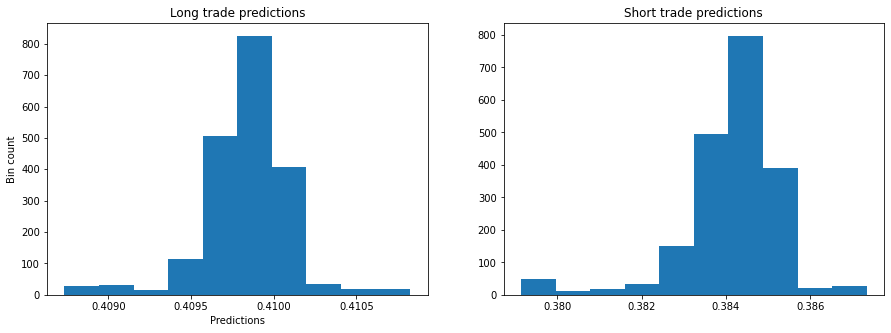

In [ ]:
#The results are in pairs for each data point with 
def results_histogram(df):

    buy_results, sell_results = np.transpose(model.predict(pxTest))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    axes[0].hist(buy_results, bins=10)
    axes[0].set_title("Long trade predictions")
    axes[1].hist(sell_results, bins=10)
    axes[1].set_title("Short trade predictions")

    for i in [0,1]:
        axes[0].set_xlabel("Predictions")
        axes[0].set_ylabel("Bin count")

results_histogram(pxTest)

Clearly, something is amiss. The model is only giving results between a very limited range, which is a large failure. I think before I can continute, I need to find the source of this error. My first instinct is that perhaps I'm not treating the LSTM properly. I've been treating it like a classifier, but I think I should be treating it like a regression algorithm. Currently, my grader function classifies a data point as either being a good long trade, or a good short trade. The idea was then the model would be able to provide a binary 0 or 1 result. As I understand it, the LSTM would be better at predicting a continuous value, such as the closing price increase from one point to the next.

I realize now, that I likely need to frame this as a regression problem instead. First, though, I'm going to try continuing as a classifier and simply change how I encode the results.

---

### 1.6 Changing the encoding scheme

#### 1.6.1 "Why does it need changing?"



When the algorithm sees two y-columns, the LSTM is designed to read that as being two timesteps into the future. Instead of seeing a buy columns and a sell column, it sees the first prediction timestep, and then the second. I need to encode the buying or selling into a single operator with range -1 to 1, encoded as follows:
*  -1 : It's a good trade to go short
*   0 : Either the trade window expired, or the result was indeterminate
*   1 : It's a good trade to go long.

I'll redefine the data prep and grader functions to account for this:
I realized when thinking about how to implement the above encoding that it was rather boring information. If I could somehow encorporate both how long it took to find the trade, as well as the resulting trade polarity. I know that the negatives will indicate a short trade, and positive will encode a long trade. I think the simplest approach seems to be to score the data uniformly, aka -1 for a short, or +1 for a long. However, this fails to capture the length of time it took to find the trade. Since I am specifying the trade parameters, I think I should incentivise trades that are executed quickly. Because of this, I'll try first using some kind of scale that incentivises quick trades over long ones, such as an inverse exponential.

I also need to be able to handle working through the data in series, and I need a way of catching exceptions where both trades execute in time. Because I am now weighing the results based on how fast they are, both results will be non-zero. I can then take the absolute value of both, and the smallest one means it executed first. This will always be true for any distribution where the incentive is strictly decreasing as you interate along looking for the trade. 

In the code below, I am using the index k+1 to assign the result in the long trade section. This will be written immediately into the output list. Next when the short trade is running

#### 1.6.2 Re-designing the grader() and dataPrep() functions

The long trade is checked first. When it finds a trade, instead of assigning a 1, it will assign the value of k+1. This ensures that there are no zeros, and the result scales into the positive with the length it took to find the trade.

I also think it's worth trying to format the data in a way that makes the most sense to the computer, a linear scale from -n_tries to n_tries is quite unwieldy, and so I should find a way to normalize the data.

In [ ]:
def grader_scaled(df, *args):
    """
    Grader function, takes a pd DataFrame 'df' as input and outputs whether or not a buy (long trade) or
        a sell (short trade) at the current data point would trigger a stop loss or a take profit within
        'n_tries' data points at a reward/risk ratio and profit level of 'rr' and 'profit', respectively.


        df        :  pandas DataFrame with shape (1,x)

        *args variables
        profit    :  Number, The desired profit, in percentage form
        rr        :  Number, The reward/risk ratio, used to calculate stop-loss and take-profit
        n_tries   :  Number, Number of data points to look into the future for the SL or TP
        exp_scale :  Number, the scaling factor for the exponential function used to encode information


    Re-design discussion: Now that the data is scaled relatively, in order to execute properly the grader
        function will now compare the TP and SL levels to the product of all entries up to the current index.
        Conveniently, the TP and SL levels are now single constants, and no longer large lists constructed from df.
    """
    # Unpack the args
    args = list(args)
    profit, rr, n_tries, exp_scale = args[0]

    # Create the inverse exponential function that will act as the scaling factor for the data.
    exp_list = np.arange(1, n_tries)
    exp_list = np.exp( -np.abs(exp_list) * exp_scale / n_tries )

    df = np.array(df)

    # First, I am calculating as if the trade is long. So, I am looking for a TP above the close, with a corresponding
    #     SL below the close. These are specified by the function parameters.

    # TP is now simply one plus the profit, which makes it in our desired form (12.3% - > 1.23)
    # SL is calculated similarly with one minus the quantity profit divided by the rr ratio
    tp_long = 1 + profit
    sl_long = 1 - (profit / rr)

    # If the trade type is short, I are looking for a TP below the close, with a corresponding SL above the close
        #     specified similarly by the profit and reward/risk ratio.
    tp_short = 1 - profit
    sl_short = 1 + (profit / rr)

    # There needs to be a running temp variable which will hold the current value of the closing tick relative to our
    #    starting tick. This will be initialized to 1 every time the outer loop runs.
    increase = 1

    result_list = np.zeros(df.shape)

    for i, val in enumerate(df):
        # Initialize values.
        # The percent increase in decimal form since k=0
        increase = 1
        # The index where the long trade executed
        i_long  = 0
        # The index where the short trade executed
        i_short = 0

        # Iterate over the next n_tries values
        # When i=0, it's being compared to itself, so instead I'll start at i+1
        for k in range(i+1, i+n_tries):

            try:
                # Find the relative change since k=0
                increase = increase*df[k]
            except IndexError:
                # This IndexError exception only triggers when (k=i+n_tries) exceeds the elements in df
                break

            # Compare to situations and assign result values accordingly. When a take-profit is triggered,
            #     the value of i_short/i_long will be positive. When stop-loss is triggered, it will be negative.
            if i_long == 0:
                if increase >= tp_long:
                    i_long = k-i-1
                elif increase <= sl_long:
                    i_long = -(k-i-1)
                
            if i_short == 0:
                if increase <= tp_short:
                    i_short = k-i-1
                elif increase >= sl_short:
                    i_short = -(k-i-1)
        
        # Note that i_long and i_short are guaranteed to have opposite sign if one is positive.
        # I did not implement the scaling of the result here, but if I wanted to, I would uncomment
        #     the below lines.
        if i_long > 0:
            result_list[i] = 1
        #   result_list[i] = exp_list[i_long]
        elif i_short > 0:
            result_list[i] = -1
        #   result_list[i] = -exp_list[i_short]

    return result_list

In [ ]:
def DataPrep(df, 
             test_ratio = 0.2,
             window_size = 10,
             return_frame = False,
             verbose = False,
             grader_params = [0.001, 2, 30],
             remove = ["date", "symbol", "Volume BTC", "tradecount", "unix"], 
             indicators = [("sma", 20), ("sd", 20), ("sma", 10), ("sd", 10)]
             ):
    """
        Parameters
    df            : Pandas DataFrame, The data set to prepare. Has known structure and layout.
    test_ratio    : Number between 0 and 1, The ratio of test data to training data
    window_size   : Number, the amount of data points per batch
    return_frame  : Whether or not I return the non-LSTM-modified DataFrame (useful for debugging)
    verbose       : Whether or not to print progress from the function call.
    grader_params : List, The parameters to be sent to the grader function (profit, rr, n)
    remove        : List, The columns to be removed
    indicators    : List, The indicators to be added
        Returns
    batch_df      : Pandas DataFrame, The rank-3 tensor to be used in the LSTM layer (batches, window, features)
    df            : Pandas DataFrame, Optional, The non-windowed DataFrame (index, features)
    """

    if verbose: print("Data prep start")
    # Define some variables to help trim later
    max_period = 0
    grader_period = grader_params[2]

    # Indexing and bulk removal -- Want oldest data first so RNN reads along positive time direction
    df = df.loc[::-1].reset_index(drop=True)
    # Index differential is used to ensure that the list did in fact get reversed
    if verbose: print("...Indexing complete. Index differential: %i" %(df["unix"].iloc[1] - df["unix"].iloc[0]))
    df = df.drop(columns = remove)
    if verbose: print("...Columns removed")

    # Any base renaming to be done
    df["vol"] = copy.copy(df["Volume USDT"])
    df = df.drop("Volume USDT", axis=1)
    if verbose: print("...Renaming complete")

    # Indicator calculator. For each tuple in "indicators", relevant information
    #    is passed to add the desired indicator to the data set. If the indicator
    #    has already been calculated and stored in the stored_indicators list,
    #    it will pull from that instead of calulating it from scratch.
    if verbose: print("...Starting indicators")
    for item in indicators:

        #Identify the indicator and period
        indicator, period = item
        #Create the label "indicator-period"
        label = indicator + "-" + str(period)
        if verbose: print("      Indicator %s identified" %label)

        # I need to know the max period of the indicators to know how much data
        #    to trim from the beginning of the data set. This is to avoid NaN in
        #    our data.
        if period > max_period:
            max_period = period

        # If I have already calculated this label and it is stored in our list:
        if label in stored_indicators.columns:
            if verbose: print("      Indicator found in stored list")
            df[label] = copy.copy(stored_indicators[label])
        # If I have not yet calculated this label
        else:
            # Use the dictionary to calculate the desired indicator and store it in df
            df[label] = indicator_dict[indicator](df["close"], period)
            # Also store the indicator in the stored list for further use
            stored_indicators[label] = copy.copy(df[label])
            if verbose: print("      New indicator %s added to list" %label)

    if verbose: print("...Indicators complete")



    if verbose: print("...Starting data scaling")
    # Iterate over each column
    for col in df.columns:

        # Iterate over each value, backwards
        for i in range(df.shape[0]-1, 0, -1):
            df.at[i, col] = df.at[i, col] / df.at[i-1, col]
        
        df.at[0,col] = 1

        if verbose: print("      Column ( %s ) Completed" %col)
    if verbose: print("...Finished data scaling")

    """
    Obsolete, now I need to scale the data based on the relative size to the previous entry. See above code.

    # Normalize all the data
    for col in df.columns:
        df[col] = normalize(df[col]) 
    if verbose: print("...Data normalized")
    """

    if verbose: print("...Grader function called")
    # Calculate the labels for the data set using the grader_params provided
    df["result"] = grader_scaled(df["close"], grader_params)
    if verbose: print("...Grader function complete")

    # Trim the data set based on the largest indicator period and the grader period
    df = df.iloc[max_period : -1*grader_period]
    if verbose: print("...Data trimmed")

    # Create the train and test splits for the data
    train, test = train_test_split(df, test_size = test_ratio, shuffle=False)
    train_labels = copy.copy(train["result"])
    train = train.drop("result", axis=1)
    test_labels = copy.copy(test["result"])
    test = test.drop("result", axis=1)
    if verbose: print("...Train-test split created")

    # Define some variables to be used during the tensor creation
    train_batches = train.shape[0] - window_size
    test_batches = test.shape[0] - window_size
    num_features = train.shape[1]

    # Create the tensor for use in the LSTM layer
    if verbose: print("...Starting tensor creation")
    batch_train = np.empty(shape = (train_batches, window_size, num_features), dtype = np.float32)
    batch_test = np.empty(shape = (test_batches, window_size, num_features), dtype = np.float32)

    if verbose: print("      Train tensor with %i batches, %i window size" %(train_batches, window_size))
    for i in range(train_batches):
        batch_train[i] = train.iloc[ i : (i + window_size) ]
    #    for v in range(window_size):
    #        batch_train[i][v] = train.iloc[i + v]
    if verbose: print("      Train tensor created with shape :", batch_train.shape)

    if verbose: print("      Test tensor with %i batches, %i window size" %(test_batches, window_size))
    for i in range(test_batches):
        batch_test [i] = test.iloc[ i : (i + window_size)]
    #    for v in range(window_size):
    #        batch_test[i][v] = test.iloc[i + v]
    if verbose: print("      Test tensor created with shape :", batch_test.shape)
    if verbose: print("...Tensor creation complete")
    if verbose: print("Data prep complete")


    if return_frame: return batch_train, batch_test, train_labels[window_size:], test_labels[window_size:], df

    return batch_train, batch_test, train_labels[window_size:], test_labels[window_size:]

### 1.7 Testing the new functions

As a bonus, the DataPrep function is now significantly faster!

In [ ]:
pGraderParams = [0.01, 2, 30, 2]
pWindowSize = 30
pxTrain, pxTest, pyTrain, pyTest, df = DataPrep(pData, verbose=True, window_size = pWindowSize, grader_params=pGraderParams, return_frame=True)

Data prep start
...Indexing complete. Index differential: 60000
...Columns removed
...Renaming complete
...Starting indicators
      Indicator sma-20 identified
      Indicator found in stored list
      Indicator sd-20 identified
      Indicator found in stored list
      Indicator sma-10 identified
      Indicator found in stored list
      Indicator sd-10 identified
      Indicator found in stored list
...Indicators complete
...Starting data scaling
      Column ( open ) Completed
      Column ( high ) Completed
      Column ( low ) Completed
      Column ( close ) Completed
      Column ( vol ) Completed
      Column ( sma-20 ) Completed
      Column ( sd-20 ) Completed
      Column ( sma-10 ) Completed
      Column ( sd-10 ) Completed
...Finished data scaling
...Grader function called
...Grader function complete
...Data trimmed
...Train-test split created
...Starting tensor creation
      Train tensor with 8079 batches, 30 window size
      Train tensor created with shape : (8079,

In [ ]:
np.unique(df["result"], return_counts=True)

(array([-1.,  0.,  1.]), array([ 265, 9499,  373]))

In [ ]:
model = tf.keras.Sequential()
model.add(LSTM(128, input_shape=pxTrain.shape[1:3], activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy', 'accuracy'])
model.fit(pxTrain, pyTrain, epochs=1, use_multiprocessing=True)

253/253 [==============================] - 16s 51ms/step - loss: 0.1031 - binary_accuracy: 0.9328 - accuracy: 0.9328


So, an accuracy of 0.932 looks quite spectacular at first, until I look a little closer. In the results column of my frame, there is about 9500 indeterminate trades (value of 0) and a remaining ~500 which are either -1 or 1. If the algorithm simply guessed 0 for every single data point, it would achieve an accuracy of 95%. I'll look at the histogram of the guesses:

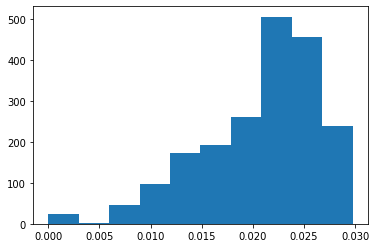

In [ ]:
y_preds = model.predict(pxTest)

plt.hist(y_preds, bins=10);

As I presumed, the model is guessing nearly zero, however there is a defined distribution here. I wonder what would happen if I massaged this data a little bit to pull out the underlying results. The prediction of zero should be the average, and then -1 and 1 should scale outward from there depending on a threshold value. A simple application would be to take the mean as the zero point, and a threshold of one standard deviation.

In [ ]:
def results_format(results, scaling = 1):

    results = np.array(normalize(copy.copy(results)))
    mean = np.mean(results)
    std = np.std(results)

    for i, val in enumerate(results):
        if val > mean+(scaling*std):
            results[i] = 1
        elif val < mean- (scaling*std):
            results[i] = -1
        else:
            results[i] = 0

    return results

y_pred_scaled = results_format(y_preds)

acc = tf.keras.metrics.Accuracy()
acc.update_state(y_pred_scaled, pyTest)
acc.result().numpy()

0.5605606

Counts of results in predictions:  (array([-1.,  0.,  1.], dtype=float32), array([ 460, 1175,  363]))
Counts of results in true values:  (array([-1.,  0.,  1.]), array([  54, 1879,   65]))


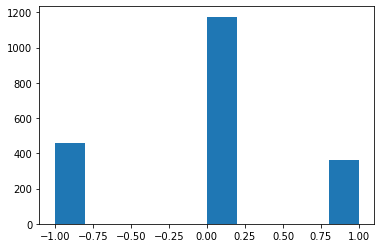

In [ ]:
plt.hist(y_pred_scaled);
print("Counts of results in predictions: ", np.unique(y_pred_scaled, return_counts=True))
print("Counts of results in true values: ", np.unique(pyTest, return_counts=True))

At the end of the day, a model like this is supposed to make money. I'll calculate the net profit if using the model, as that will be the most reliable metric to use. It's useful to see above that all predicted and true values are now in +1, 0, -1, which will make it easier to calculate the net profit.

In [ ]:
def net_profit(y_pred, y_true, profit):

    # Start at a net profit of 0, no gain or loss. Make sure to use the same
    #     profit as was used in the data prep. Profit is also sent as a multiplicative value,
    #     i.e. 0.01 => a 1% profit. If I am spending $100 every trade, then the net profit is the
    #     sum of successful and unsuccessul trades, each individually yielding a profit of +/- 'profit'.

    net_profit = 0
    
    for i,val in enumerate(y_pred):

        # However, I would not be entering into an indeterminate trade, and so I must only consider non-zero
        #     entries
        if val != 0:

            # Knowing that our values are exactly -1 or 1 at this point, it's a simple matter of equating for
            #      the result.
            if val == y_true.iloc[i]:
                net_profit += profit
            else:
                net_profit -= profit
    
    return net_profit

print(net_profit(y_pred_scaled, pyTest, pGraderParams[0]))

-8.069999999999872


Now that this metric is defined, I'll vary the scaling factor in result_format to get the highest profit possible. I'll be using a scipy minimization function. In order to use that, we need the profit to be in the negative. I'll splice the two above functions to make something that will be passable to the scipy minimize function.

In [ ]:
def minimizer_function(scaling_factor = 1 , *args):
    y_pred, y_true, profit = args[0]

    # Scaling section
    y_pred = np.array(normalize(copy.copy(y_pred)))
    mean = np.mean(y_pred)
    std = np.std(y_pred)

    for i, val in enumerate(y_pred):
        if val > mean+(scaling_factor*std):
            y_pred[i] = 1
        elif val < mean- (scaling_factor*std):
            y_pred[i] = -1
        else:
            y_pred[i] = 0

    # Profit Section
    net_profit = 0
    
    for i,val in enumerate(y_pred):
        if val != 0:
            if val == y_true.iloc[i]:
                net_profit += profit
            else:
                net_profit -= profit
    
    return -net_profit

minimizer_function(1, (y_preds, pyTest, pGraderParams[0]))

8.069999999999872

Same result as above, now with a negative sign in front since we want profit to be negative for minimization. Let's pass this to the scipy optimizer!

In [ ]:
from scipy.optimize import minimize_scalar

minimize_scalar(minimizer_function, args=[y_preds, pyTest, pGraderParams[0]])

     fun: 0
    nfev: 37
     nit: 32
 success: True
       x: 2.514978237480026

In [ ]:
minimizer_function(2.515, (y_preds, pyTest, pGraderParams[0]))

0

It seems like the limit has been reached, even with scaling the function optimially it still plateaus at zero net profit. At this point, I've ran out of time for the project, and if it gets updated in the future it will be after the time I wanted to have it finished.

## Summary

In the end, here are the key points:

### DataPrep Function
The final DataPrep function, which takes DataFrame input with known formatting. This function will:
* Remove desired columns
* Add desired technical indicators
* Grade the data using the grader function, which assigns a value in [-1, 0, 1] depending on the result of the trade
* Split the data into training and testing sets, which are already batched for use in the LSTM as 3-D tensors

All of the above points are able to be modified through the arguments sent to the DataPrep function.

The DataPrep function went through two iterations, the first of which simply normalized all the data across the entire set. This seemed counterintuitive to me once I thought more about it, as the more important piece of data is the relative change between data points, not the absolute value.

The second iteration of the DataPrep function addressed this by scaling the data relative to the previous value. That is, if point A had a value of 100 and point B had a value of 110, point B would be replace with a 1.1, meaning it was 1.1x(point A). The first element was chosen to have a value of 1.

### Grader Function
The final Grader function, which takes the DataFrame column of closing prices. This function also takes the desired profit, reward/risk ratio, and number of timesteps, in order to calculate whether or not a trade at each point would result in a success. This result is encoded as an element of [-1, 0, 1], depending on whether or not a short trade would succeed, the trade was indeterminate, or a long trade would succeed, respectively.

Because the Grader and DataPrep functions were so closely related, the Grader function also had two iterations. In the first iteration, the Grader function considered the absolute price levels in order to determine if the trade was successful. This got more complicated when the DataPrep function scaled the data to be relative. The final Grader function used different math to compare whether or not the trade was successful, based on the sequential relative increases in price from one data point to the next.

### LSTM Network 

Likely the weakest part of the project, my implementation of the LSTM network was likely lacking in several key areas. While I don't know them now, I will continue to work on this project and hopefully reach a point where I understand where all my shortcomings were located. My initial list of guesses looks something like this:

* Perhaps the data being normalized holds more weight than I gave credit
* Custom metrics for accuracy which exclude the indeterminate trades would provide stronger insight
* Using more combinations of TAs to see if performance of the model increases

**The single most important factor, in my opinion, is the loss function**

I think a custom loss function is the single best improvement I can make for this type of problem. I think there is nothing inherently wrong with the classifier approach I have taken, but no loss function properly takes it into account. There is no loss, or gain, when a prediction of zero is made, and the result is zero. It is much more important to know the result of the trade when a prediction was really made. If I return to this project, the first change I would make is to implement a custom loss function which ignores all predictions of zero.


# ADPPENDIX

Also known as my other failed attempts. It is not necessarily as well documented, especially near the end. The summary of the approaches are:

First, using a basic classifier algorithm with several technical indicators
Second, using a standard deep learning network with several technical indicators

At this point, I realized I should likely be using recurring neural networks, and that is where the above section started, chronologically.

## Naive approach

### Key points:
There are a few important notes about how the algorithm will be designed and implemented, and I've summarised them below:

*   TA Indicators
    *   Several TA indicators will be implemented in the first section of this notebook
    *   Different combinations of TA indicators will be tested when training the algorithm in order to find the highest performing combination.
*   Moving Averages (MAs)
    *   The MA is a fundamental tool in technical analysis, and so I will be using a spread of MAs to assist in our training.
    *   The MA periods will be determined by something along the lines of: 
$(MA)_i = 2 \lceil(x^i)\rceil$
    *   That is, the $i$'th MA to be used will be the $i$'th power of $x$, where I let $x$ vary between 1 and 2.
*   Redundancy
    *    To make the data easier to parse, any TA indicators that return an absolute price level in any way (e.g. moving averages, bollinger bands, etc.) will instead be returned in terms of relative price level (i.e. percent difference from current price level).
*   Trades
    *    Trades will be executed using a standardized $100. The goal is to find the percent profit, and so it makes things easier to standardize the trade amount.
    *    Each iteration of the training algorithm will use a different risk/reward (r/r) ratio.
    *    The output of the algorithm will, in some way, indicate either a buy, or a sale, at each particular data point. This information will be combined with the 
    *    Whether or not the trade is executed will depend on if the expected yield from the trade is above the so-called "trade threshold", i.e. 5% (most likely much, much smaller in practice)


## Success Measurement

Success will be measured using a binary pass/fail system. The algorithm will 

## Starting with the data

In [ ]:
#Useful imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

#Trimming and naming columns/rows
raw = pd.read_csv("/content/drive/My Drive/Machine Learning/BTCUSDT Analysis/binance_BTCUSDT_1h.csv")
raw

,https://www.CryptoDataDownload.com,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
1,1.64E+12,2021-12-12 0:00,BTC/USDT,49389.99,49577,49301.07,49482.13,591.84649,29259916.06,17040
2,1.64E+12,2021-12-11 23:00,BTC/USDT,48826.36,49485.71,48793.65,49389.99,1303.91272,64211479.93,45868
3,1.64E+12,2021-12-11 22:00,BTC/USDT,48779.31,49146.21,48628.36,48826.36,821.94948,40150780.57,32006
4,1.64E+12,2021-12-11 21:00,BTC/USDT,48564.06,48839.95,48390.22,48782.79,693.14915,33652418.81,28574
...,...,...,...,...,...,...,...,...,...,...
40492,1502956800,2017-08-17 08-AM,BTC/USDT,4349.99,4377.85,4333.32,4360.69,0.9499,4139.7,NaN
40493,1502953200,2017-08-17 07-AM,BTC/USDT,4324.35,4349.99,4287.41,4349.99,4.44,19241.06,NaN
40494,1502949600,2017-08-17 06-AM,BTC/USDT,4315.32,4345.45,4309.37,4324.35,7.23,31282.31,NaN
40495,1502946000,2017-08-17 05-AM,BTC/USDT,4308.83,4328.69,4291.37,4315.32,23.23,100304.82,NaN


In [ ]:
data = raw.set_axis(raw.loc[0], axis=1)
#Trim unnecessary rows and columns
data = data.drop(0, axis=0)
data = data.drop("unix", axis=1)
data = data.drop("symbol", axis=1)
data = data.drop("Volume USDT", axis=1)
data = data.drop("tradecount", axis=1)

#Make a new DataFrame for the new days and times columns
dates = data["date"]
times = copy.copy(dates)
days = copy.copy(dates)
for i in range(1,40497):
    #Split using whitespace to separate day and time
    t_ = dates[i].split(" ")
    #Assign day variable
    d_ = t_[0]
    #Split day by year, month, and day
    d_ = d_.split("-")
    #Assign time value
    t_ = t_[1][0:2] + ":00"
    #Fixing an error -- optimize this bit later
    if t_ == "0::00":
        t_ = "00:00"
    #Assign new values to columns
    times[i] = t_
    days[i] = d_
#Assign columns to place in data
data["YY/MM/DD"] = days
data["Time"] = times
#Date table is now redundant
data = data.drop("date", axis=1)
#Weird data point, goodbye
data = data.drop(40496)
#Reverse table and reindex so time flows with the row index
data = data[::-1]
data = data.set_axis(np.arange(1,40496,1),axis=0)
data["VOL"] = data["Volume BTC"]
data = data.drop("Volume BTC", axis=1)
#Reorder columns for visual clarity
data = data[["Time", "YY/MM/DD", "open", "close", "high", "low", "VOL"]]
data["high"] = pd.to_numeric(data["high"])
data["low"] = pd.to_numeric(data["low"])
data["open"] = pd.to_numeric(data["open"])
data["close"] = pd.to_numeric(data["close"])
data["VOL"] = pd.to_numeric(data["VOL"])
data

,Time,YY/MM/DD,open,close,high,low,VOL
1,05:00,"[2017, 08, 17]",4308.83,4315.32,4328.69,4291.37,23.23000
2,06:00,"[2017, 08, 17]",4315.32,4324.35,4345.45,4309.37,7.23000
3,07:00,"[2017, 08, 17]",4324.35,4349.99,4349.99,4287.41,4.44000
4,08:00,"[2017, 08, 17]",4349.99,4360.69,4377.85,4333.32,0.94990
5,09:00,"[2017, 08, 17]",4360.69,4444.00,4445.78,4360.00,10.76000
...,...,...,...,...,...,...,...
40491,20:00,"[2021, 12, 11]",48407.25,48564.07,48736.94,48391.68,636.46533
40492,21:00,"[2021, 12, 11]",48564.06,48782.79,48839.95,48390.22,693.14915
40493,22:00,"[2021, 12, 11]",48779.31,48826.36,49146.21,48628.36,821.94948
40494,23:00,"[2021, 12, 11]",48826.36,49389.99,49485.71,48793.65,1303.91272


### TA Indicators

Now, I need to decide on which TA indicators the algorithm will consider. Certain TAs such as moving average are an absolute necessity, as they are often used to calculate further TAs. These will be implemented as-needed for such further TAs. The first TA I wish to employ are Bollinger Bands. The Bollinger Bands use a moving average, with the standard being 20 ticks. I will use this for the algorithm.

#### MA and STD Functions

In [ ]:
def get_sma(items, n):
    """
    get_sma() function will return the simple moving average for the list "items" with period "n".
    """
    return items.rolling(n).mean()

def get_std(items, n):
    """
    get_std() function will return the standard deviation for the list "items" with period "n".
    """
    return items.rolling(n).std()

#### Bollinger Bands (20-day)
Bollinger Bands are simply the moving average of a period plus and minus two standard deviation in each direction:
$$BB = SMA + (2*STD)$$

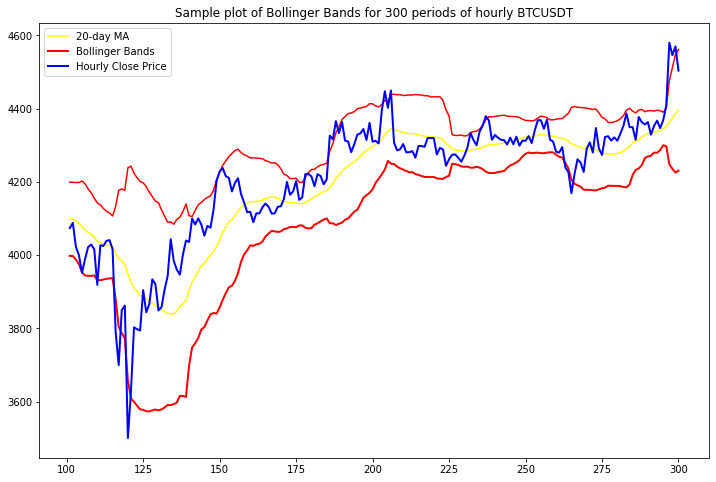

In [ ]:
def get_bollinger_bands(items, n):
    sma = get_sma(items, n)
    std = get_std(items, n)
    boll_up = sma + (2*std)
    boll_dn = sma - (2*std)
    return boll_up, boll_dn

boll_up, boll_dn = get_bollinger_bands(data["close"], 20)
data["BB_up_20"], data["BB_dn_20"] = boll_up, boll_dn

fig = plt.figure(figsize=(12,8))
data["SMA_20"] = get_sma(data["close"], 20)
data["SMA_50"] = get_sma(data["close"], 50)
plt.plot(data["SMA_20"][100:300],label="20-day MA",color="Yellow")
plt.plot(data["BB_up_20"][100:300],color="Red")
plt.plot(data["BB_dn_20"][100:300],color="Red",label="Bollinger Bands", linewidth=2)
plt.plot(data["close"][100:300],label="Hourly Close Price",color="Blue", linewidth=2)
plt.title("Sample plot of Bollinger Bands for 300 periods of hourly BTCUSDT")
plt.legend();

#### Average True Range (20-day)
Average True Range considers three quantities:
*   HL = High - Low
*   HC = |High - Previous Close|
*   LC = |Low - Previous Close|

For each data point, keep only the maximum of the above three quantities:
$TR_i$ = Max(HL, HC, LC). Lastly, average these quantities over the desired period.

$$ATR = \frac{1}{n}\sum_{i=-n}^0 TR_i$$



In [ ]:
def get_atr(High, Low, Close, n):
    TRs = copy.copy(High)
    for i in range(2,len(High)+1):
        HL = High[i] - Low[i]
        HC = abs(High[i]-Close[i-1])
        LC = abs(Low[i]-Close[i-1])
        TRs[i] = max(HL,HC,LC)
    return TRs.rolling(n).mean()

data["ATR"] = get_atr(data["high"], data["low"], data["close"], 20)
data[60:70]

,Time,YY/MM/DD,open,close,high,low,VOL,ATR,BB_up_20,BB_dn_20,SMA_20,SMA_50
61,05:00,"[2017, 08, 19]",4000.00,4027.37,4048.99,3976.72,3.0700,95.5980,4187.809865,3931.863135,4059.8365,4182.2344
62,06:00,"[2017, 08, 19]",4027.37,4086.29,4096.00,4013.69,16.9600,90.0605,4184.577095,3932.349905,4058.4635,4176.8766
63,07:00,"[2017, 08, 19]",4086.29,4076.12,4103.92,4073.47,1.6200,89.0530,4181.088570,3932.613430,4056.8510,4171.3154
64,08:00,"[2017, 08, 19]",4076.12,4075.98,4103.92,4051.47,2.9900,86.9740,4166.656582,3938.294418,4052.4755,4167.6956
65,09:00,"[2017, 08, 19]",4075.98,4074.23,4149.99,4074.23,3.9500,88.6830,4154.289777,3943.231223,4048.7605,4162.6756
66,10:00,"[2017, 08, 19]",4074.23,4139.98,4141.00,4074.23,2.3600,90.2480,4150.148721,3945.731279,4047.9400,4158.9706
67,11:00,"[2017, 08, 19]",4139.98,4139.98,4139.98,4120.78,0.0527,87.3840,4150.488758,3945.534242,4048.0115,4155.0992
68,12:00,"[2017, 08, 20]",4139.98,4086.09,4139.98,4044.00,2.3400,86.6960,4152.426829,3945.379171,4048.9030,4150.0850
69,01:00,"[2017, 08, 20]",4086.09,4082.53,4086.09,4052.82,1.0600,83.5535,4153.048268,3945.310732,4049.1795,4146.0340
70,02:00,"[2017, 08, 20]",4082.53,4124.69,4124.69,4082.53,2.3700,80.9050,4160.816879,3951.324121,4056.0705,4142.7972


## Deep Learning Approach



The above is nice and fancy and all, but I never really took the time to research what algorithms I should use. A deep learning network seems intuitive, since this is a complex problem and I would like some flexibility with the algorithm that a strict regression or classification algorithm cannot supply.

I also believe that I should focus on a few high quality indicators, rather than many many constructed indicators. Of course, when creating the final product, I will let the numbers decide which indicators I should use. For the time being, I will simply use a few standard deviation and moving average indicators.


### The Grader Function

The cornerstone of this approach is the grader function in the code block below. This is a compromise to label the data, since ideally the algorithm would be able to place both long and short orders, as well as vary the amount placed on each trade. However, I do not know of a way to allow the network to calculate the true value of a label during the training, as would be required for such a flexible algorithm.

Instead, I train the algorithm to always place long trades with specified stop-loss (SL) and take-profit (TP) levels. These levels are decided based on the following variables:

*    Reward/risk ratio: The reward to risk ratio is the ratio of potential profit to the potential loss.
*    Profit level: The desired TP level for the trade, in terms of percentage increase.

Both the reward to risk ratio and the profit level need to be specified to the grader function. The last missing piece is the amount of data points to check for the specified TP/SL levels. Of course, I could let the algorithm go on forever until either the TP or SL is triggered, but since the algorithm is designed to work on short timescales, I should limit the grader function to work in this scope.

With all these variables, the grader function executes as follows. Given the arguments:
* df     : A dataframe of shape (1,X) with all the closing prices is sent to the function.
* profit : The desired profit percentage on the trade
* rr     :The desired reward to risk ratio
* n      :The amount of data points to check

For every data point in 'df', the function will iterate over the next 'n' data points immediately following the current data point d[i]. If at any point d[i] exceeds the TP level (1+profit) or falls below the SL level (1-$profit/rr) then the current loop iteration will break and return 1 or 0. A 1 corresponds to a successful trade, and a 0 represents a failed trade.

In [ ]:
#Useful imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense

def get_sma(items, n):
    """
    get_sma() function will return the simple moving average for the list "items" with period "n".
    """
    return items.rolling(n).mean()

def get_std(items, n):
    """
    get_std() function will return the standard deviation for the list "items" with period "n".
    """
    return items.rolling(n).std()

def normalize(df):
    return (df-df.min())/(df.max()-df.min())

def grader(df, profit=0.03, rr = 2, n = 40):
    """
    Grader function, takes a pd DataFrame 'df' as input and outputs whether or not a buy
        at the current data point would trigger a stop loss or a take profit within
        'n' data points at a reward/risk ratio of 'rr.
        df      :  pandas DataFrame with shape (1,x)
        profit  :  The desired profit, in percentage form
        rr      :  The reward/risk ratio, used to calculate stop-loss and take-profit
        n       :  The number of data points to look into the future for the SL or TP.
    """
    #rr is reward/risk ratio
    sl = copy.copy(df) * (1-profit/rr)
    tp = copy.copy(df) * (1+profit)

    for i, buy in enumerate(df):

        if i==df.shape[0] - n:
            df.iloc[-n:] = 0

        for k in range(i, i+n):
            #SL Trigger
            if buy <= sl.iloc[k]:
                df.iloc[i] = 0
                break
            #TP Trigger
            elif buy >= tp.iloc[k]:
                df.iloc[i] = 1
                break
            df.iloc[i] = 0
    return df

In [ ]:
raw = pd.read_csv("/content/drive/MyDrive/Machine Learning/BTCUSDT Analysis/binance_BTCUSDT_1h.csv")
data = raw.set_axis(raw.loc[0], axis=1)

#Trim unnecessary rows and columns
data = data.drop(0, axis=0)
data = data.drop("unix", axis=1)
data = data.drop("symbol", axis=1)
data = data.drop("Volume USDT", axis=1)
data = data.drop("tradecount", axis=1)

#Make a new DataFrame for the new days and times columns
dates = data["date"]
times = copy.copy(dates)
days = copy.copy(dates)
for i in range(1,40497):
    #Split using whitespace to separate day and time
    t_ = dates[i].split(" ")
    #Assign day variable
    d_ = t_[0]
    #Split day by year, month, and day
    d_ = d_.split("-")
    #Assign time value
    t_ = t_[1][0:2] + ":00"
    #Fixing an error -- optimize this bit later
    if t_ == "0::00":
        t_ = "00:00"
    #Assign new values to columns
    times[i] = t_
    days[i] = d_
#Assign columns to place in data
data["YY/MM/DD"] = days
data["Time"] = times
#Date table is now redundant
data = data.drop("date", axis=1)
#Weird data point, goodbye
data = data.drop(40496)
#Reverse table and reindex so time flows with the row index
data = data[::-1]
data = data.set_axis(np.arange(1,40496,1),axis=0)
data["VOL"] = data["Volume BTC"]
data = data.drop("Volume BTC", axis=1)
#Reorder columns for visual clarity
data = data[["Time", "YY/MM/DD", "open", "close", "high", "low", "VOL"]]
data["high"] = pd.to_numeric(data["high"])
data["low"] = pd.to_numeric(data["low"])
data["open"] = pd.to_numeric(data["open"])
data["close"] = pd.to_numeric(data["close"])
data["VOL"] = pd.to_numeric(data["VOL"])
data

,Time,YY/MM/DD,open,close,high,low,VOL
1,05:00,"[2017, 08, 17]",4308.83,4315.32,4328.69,4291.37,23.23000
2,06:00,"[2017, 08, 17]",4315.32,4324.35,4345.45,4309.37,7.23000
3,07:00,"[2017, 08, 17]",4324.35,4349.99,4349.99,4287.41,4.44000
4,08:00,"[2017, 08, 17]",4349.99,4360.69,4377.85,4333.32,0.94990
5,09:00,"[2017, 08, 17]",4360.69,4444.00,4445.78,4360.00,10.76000
...,...,...,...,...,...,...,...
40491,20:00,"[2021, 12, 11]",48407.25,48564.07,48736.94,48391.68,636.46533
40492,21:00,"[2021, 12, 11]",48564.06,48782.79,48839.95,48390.22,693.14915
40493,22:00,"[2021, 12, 11]",48779.31,48826.36,49146.21,48628.36,821.94948
40494,23:00,"[2021, 12, 11]",48826.36,49389.99,49485.71,48793.65,1303.91272


In [ ]:
trim = pd.DataFrame([])
trim["margin"] = normalize(data["high"] - data["low"])[12040:]
trim["movement"] = normalize(data["open"] - data["close"])[12040:]
trim["close"] = normalize(data["close"])
trim["vol"] = normalize(data["VOL"])
trim["bb_up_20"], trim["bb_down_20"] = get_bollinger_bands(trim["close"], 20)
trim["sma_20"] = get_sma(trim["close"], 20)
trim["sd_20"] = get_std(trim["close"], 20)
trim["results"] = grader(copy.copy(trim["close"]), profit=0.005, rr=2)

i=0
for item in trim["results"]:
    if item == 1:
        i+=1
print(i)

trim = trim.iloc[20:-20]

NameError: ignored

In [ ]:
trim_train, trim_test = train_test_split(trim, test_size=0.2)
trim_train

,margin,movement,close,vol,bb_up_20,bb_down_20,sma_20,sd_20,results
33646,0.039382,0.521948,0.660695,0.041695,0.667936,0.608875,0.638405,0.014765,0.0
36198,0.077111,0.444791,0.574970,0.099599,0.575051,0.560207,0.567629,0.003711,1.0
27163,0.029784,0.505658,0.129070,0.189578,0.129549,0.127716,0.128632,0.000458,1.0
38451,0.068237,0.518541,0.673769,0.065304,0.689401,0.672094,0.680748,0.004327,0.0
21067,0.005306,0.512331,0.078709,0.019214,0.080166,0.077372,0.078769,0.000698,0.0
...,...,...,...,...,...,...,...,...,...
14383,0.003055,0.511468,0.034578,0.034441,0.036213,0.032756,0.034484,0.000864,1.0
29084,0.005531,0.514836,0.118047,0.041631,0.119619,0.117888,0.118753,0.000433,0.0
40360,0.143765,0.606142,0.677309,0.087864,0.712025,0.681983,0.697004,0.007510,0.0
40432,0.075198,0.551091,0.704378,0.042673,0.732461,0.704910,0.718685,0.006888,0.0


### Data is in

Now gotta iterate over different combinations of MA and ST.DEV.. I think now is the time to create the framework for the model so I can start iterating over different combinations.

In [ ]:
# Here's the prototype model architecture
model = tf.keras.Sequential()
model.add(Dense(18, input_dim=trim_train.shape[1]-1, activation='relu'))
model.add(Dense(9, activation='relu'))
model.add(Dense(1, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(trim_train.iloc[:,:-1], trim_train.iloc[:,-1], epochs=3, batch_size=16)

Epoch 1/3
1421/1421 [==============================] - 5s 3ms/step - loss: 0.6782 - accuracy: 0.4086
Epoch 2/3
1421/1421 [==============================] - 5s 3ms/step - loss: 0.6761 - accuracy: 0.4086
Epoch 3/3
1421/1421 [==============================] - 5s 3ms/step - loss: 0.6761 - accuracy: 0.4086


In [ ]:
y_pred = model.predict(trim_test.iloc[:,:-1])
confusion_matrix(trim_test["results"], y_pred)

array([[   0, 3329],
       [   0, 2354]])

### Clearly this is trash

It's obvious that this approach will likely not work, and the missing component is that the network is looking at isolated data points, when context is extremely important for analyzing price of BTC. Instead, an algorithm such as an LSTM layer would be much better suited for this problem. In the next section I will use a minute chart instead of hourly, as well as implement some new algorithms that encorporate previous information.

### Key Points
An algorithm that is able to use the context of the chart is necessary for the success of the project. I do not want to lose the flexibility of the deep-learning framework, and so this leads directly to using RNN layers in the training of the model. Based on what I've learned from the previous sections, these are some of the key points for implementing this new version: